In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science
## Homework 1: Webscraping, Pandas, and EDA

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb

<hr style="height:2.4pt">

In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import pyarrow as pa # optional
import seaborn as sns
import matplotlib.pyplot as plt
import re
import io
import os.path
import json
import time
import glob
import asyncio # optional
import aiohttp # optional
from IPython.core.display import HTML
from IPython import display

import wikipedia
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import asyncio
from collections import defaultdict

In [3]:
# For calculating total notebook runtime
notebook_start = time.time()

In [4]:
style = '''<style>
h3, h4 {
    background-color: #7efcf5;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0em;
}
h3 {
    background-color: #7efcf5;
    border-top: 5px solid #7ec4fc;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0.5em;
}
p {
    padding: 0.5em;
    max-width: 34em;
    font-weight:400;
}
.md {
    max-width: 80ch;

}
.prompt {    
    background-color: lightgreen;
    border-color: #dFb5b4;
    border-left: 5px solid #f57efc;
    padding: 0.5em;
    font-weight:500;
    }
 </style>'''
HTML(style)

## Assignment Overview

You'll be working with data from screenboston.com, a website that aggregates movie screenings from various theaters in the Boston area. Your task is to collect this data, enrich it with information from Wikipedia, and then analyze and visualize the results.

## Assignment Structure

The assignment is divided into 8 main questions, each building upon the previous ones, followed by a wrap-up:

1. Fetching HTML from screenboston.com (10 pts)
2. Parsing HTML into structured data (15 pts)
3. Augmenting data with historical snapshots (15 pts)
4. Creating and manipulating a Pandas DataFrame (15 pts)
5. Initial exploratory data analysis and visualization (15 pts)
6. Finding Wikipedia pages for each screened film (7 pts)
7. Storing Wikipedia HTML in the DataFrame (3 pts)
8. Extracting and analyzing data from Wikipedia pages (15 pts)
9. Wrap-up (5 pts)

As you progress through these steps, you'll be transforming raw web data into a rich dataset ready for analysis. By the end, you'll have created a comprehensive overview of Boston's movie screening landscape, potentially uncovering interesting trends and patterns in the process. 

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output. Or better yet, avoid overly long output altogether.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<div class=md>
<h3>1. Getting HTML from screenboston.com</h3>

<p>Our first step is to get the HTML content from the page at screenboston.com for analysis. To avoid having to make unnecessary future requests, you should write the content to disk.</p>



<div class=prompt>
    
1. Use the `requests` library to get the html located at screenboston.com.
1. Save it in the file `data/html/screenboston.html`.

**Your code should only make an HTTP request if the file does not already exist.** 

**Hint:** the `os.path.isfile()` function can be used check if a file exists.
</div>
</div>


In [ ]:
out_path = "./data/html/screenboston.html"

# Create the directory if it does not exist
os.makedirs(os.path.dirname(out_path), exist_ok=True)

# Check if the file already exists
if not os.path.isfile(out_path):
    # If not, download the HTML from the URL
    url = "http://screenboston.com"
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    # Save the content to the file, specifying utf-8 encoding
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(response.text)

# Read the HTML content from the file into the 'html' variable
with open(out_path, "r", encoding="utf-8") as f:
    html = f.read()

In [30]:
grader.check("q1")

q1 results: All test cases passed!

<div class=md>
<h3>2. Parsing HTML into an Efficient Data Structure</h3>

<p>Were you to open this HTML file in an editor, you'd find it wouldn't make for light reading.
There's a lot of text in there, but we're currently only interested in a small portion of it. Thankfully, this small portion's constituant occurances appear in a mostly predictable way.
</p>

<div class='prompt'>
1. Parse the HTML page to produce an iterable of dictionaries called <code>movies</code>. Here is one possible example:
<div style="max-width:30em;padding:1em">
    
```python
{'title': 'Monty Python and the Holy Grail',
 'directors': 'Terry Jones, Terry Gilliam',
 'year': 1975,
 'genre': 'Adventure',
 'runtime': '1h 31m',
 'theater': 'Coolidge Corner Theater',
 'screen_date': '2024-08-17'
 'screen_times': '11:59 PM'}
```
</div>

2. Report the number of dictionaries in your iterable.
3. Display an example dictionary.
</div>

<p>
<b>One possible approach:</b> leveraging the structure of the page, use BeautifulSoup to divide it into disjoint peices of the HTML tree, each containing the set of information outlined above for each title's screening date at a given theater. Each peice is processed by a helper function(s) which extracts the desired fields and assemples them into a dictionary. These dictionaries are then accumulated in some iterable such as a list.
</p>

**Hints:**
- Your browser's 'inspect' tool is very useful for exploring a page's structure.
- To maintain a uniform set of keys across all movie dictionaries, use the plural 'directors' even for movies which attribute only a single director. 
</div>
</div>

In [ ]:

soup = BeautifulSoup(html, "html.parser")

def norm(s):
    return re.sub(r"\s+", " ", (s or "").strip())

def parse_details(s): 
    parts = [p.strip() for p in s.split(",")]
    year = int(re.search(r"\d{4}", parts[0]).group()) if parts else None
    genre = parts[1] if len(parts) > 1 else ""
    runtime = parts[2] if len(parts) > 2 else ""
    return year, genre, runtime

movies = []

# id="YYYY-MM-DD"
for day in soup.select('div.max-w-screen[id]'):
    m = re.match(r"\d{4}-\d{2}-\d{2}", day.get("id",""))
    if not m:
        continue
    screen_date = m.group(0)

    for card in day.select("button"):
        title_tag = card.select_one("p.big")
        if not title_tag:
            continue
        title = norm(title_tag.get_text())

        info_blocks = card.select("div.flex.child\\:flex-1 div")
        if len(info_blocks) < 2:
            continue

        p_tags_left = info_blocks[0].find_all("p")
        if len(p_tags_left) < 2:
            continue
        directors = norm(p_tags_left[0].get_text())
        year, genre, runtime = parse_details(norm(p_tags_left[1].get_text()))

        # right block: theater + times
        theater = norm(info_blocks[1].find("p").get_text())
        times = [norm(p.get_text()) for p in info_blocks[1].select("div.flex p")]
        screen_times = ", ".join([t for t in times if t])

        movies.append({
            "title": title,
            "directors": directors,   # always plural key
            "year": year,
            "genre": genre,
            "runtime": runtime,     
            "theater": theater,
            "screen_date": screen_date,   # ISO date from the day-section id
            "screen_times": screen_times
        })

len(movies)

95

In [45]:
grader.check("q2")

q2 results: All test cases passed!

<div class=md>
    <h3>3. Adding Historical Data: Snapshots from the Internet Archive's Wayback Machine</h3>
<p>
The screenboston.com page only shows screenings scheduled from the current day until about 2-4 weeks into the future.
Using the <a href="http://web.archive.org/">Wayback Machine</a>, we can augment our dataset with past snapshots of the page  
</p>

<p>
Rather than clicking around to download each snapshot manually, we should again acquire our pages programmatically using <code>requests</code>. The Internet Archive offers an <a href='https://archive.org/help/wayback_api.php'>API</a> where you can specify a URL and timestamp and receive a JSON object which contains a new URL to a snapshot of the desired page nearest to the provided timestamp. You can then use <code>requests</code> again to acquire the HTML of this snapshot.
</p>
    
<div class=prompt>

1. Acquire enough snapshots to cover all days from Jan through September 2024 for which there exists data. 
For simplicity we'll assume that any well-formed screenboston.com page will cover at least through the end of that month and that a day's schedule won't change once displayed.
2. Write each snapshot's HTML content to disk in the `/data/html` directory using filenames of the form `'snapshot_YYYYMMDD.html'`. Your code should only make requests if no local snapshot files already exist.
3. Using your parsing function from the previous section, add movie dictionaries extracted from all the snapshots to your list, `movies`. Save this list of dictionaries as 'data/movies.json'. You should only perform the parsing if the JSON file does not already exist. Don't worry about any duplicate movie screenings in your list at this point.

</div>

**Hints:**
- When retrieving JSON content with <code>requests</code>, us the `json()` method rather than the `text` attribute to extract the content from the returned request object into a nested dictionary rather than a string.
- APIs often take parameters as key-value pairs occuring after a '?' character in the URL. For example 'http://archive.org/wayback/available?url=example.com&timestamp=20060101' includes a 'url' and a 'timestamp' parameter. When using <code>requests.get()</code> you can exclude these parameters from the URL itself and instead pass them as a dictionary to an argument called 'params'.
- Use <code>json.dump()</code> and <code>json.load()</code> from the imported <code>json</code> module for writing and reading JSON content.

In [ ]:
# Wayback API endpoint and target site
WAYBACK = "http://archive.org/wayback/available"
TARGET = "https://screenboston.com"
HTML_DIR = "data/html"

# create folder if not already there
if not os.path.exists(HTML_DIR):
    os.makedirs(HTML_DIR)

def save_snapshot(ts):
    # ts format: YYYYMMDD
    out_path = os.path.join(HTML_DIR, f"snapshot_{ts}.html")
    if os.path.exists(out_path):
        return
    
    # ask Wayback API for a snapshot
    try:
        resp = requests.get(WAYBACK, params={"url": TARGET, "timestamp": ts}, timeout=20)
        j = resp.json()
    except Exception:
        return
    
    # get url
    snap = j.get("archived_snapshots", {}).get("closest", {})
    url = snap.get("url")
    if not url:
        return
    
    # download the snapshot page
    try:
        page = requests.get(url, timeout=30)
        html = page.text
    except Exception:
        return
    
    # write html to file
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(html)

# pick one date 
months = [f"2024{m:02d}15" for m in range(1, 10)]
for ts in months:
    try:
        save_snapshot(ts)
    except Exception:
        pass
    time.sleep(0.3)


In [ ]:
def norm(s):
    # collapse whitespace
    return re.sub(r"\s+", " ", (s or "").strip())

GENRES = ["Comedy","Drama","Horror","Sci-Fi","SciFi","Science Fiction","Romance",
          "Documentary","Action","Thriller","Fantasy","Animation","Crime","Mystery",
          "Adventure","Musical","War","Western","Biography","History","Family","Noir"]

def parse_details(s: str):
    tks = [t.strip() for t in (s or "").split(",") if t.strip()]
    year, genre, runtime = None, "", ""
    # year anywhere
    for i, tok in enumerate(tks):
        m = re.search(r"\b(19|20)\d{2}\b", tok)
        if m: year = int(m.group(0)); y_idx = i; break
    else:
        y_idx = None
    # genre near year first, else anywhere
    if y_idx is not None:
        for j in range(y_idx+1, min(y_idx+4, len(tks))):
            if any(re.search(rf"\b{re.escape(g)}\b", tks[j], re.I) for g in GENRES):
                genre = tks[j]; break
    if not genre:
        for tok in tks:
            if any(re.search(rf"\b{re.escape(g)}\b", tok, re.I) for g in GENRES):
                genre = tok; break
    # runtime anywhere
    for tok in tks:
        if re.search(r"\d+\s*h(\s*\d+\s*m)?|\b\d+\s*m(in)?\b", tok, re.I):
            runtime = tok; break
    return year, genre, runtime

def parse_movies_from_html(html_text):
    # extract movie dicts from the given HTML
    soup = BeautifulSoup(html_text, "html.parser")
    out = []
    
    # day sections use id="YYYY-MM-DD"
    for day in soup.select('div[id]'):
        day_id = day.get("id", "")
        m = re.match(r"\d{4}-\d{2}-\d{2}", day_id)
        if not m:
            continue
        screen_date = m.group(0)
        
        # each screening is typically inside <button>
        for card in day.select("button"):
            # title
            title_tag = card.select_one("p.big") or card.find(["h3", "h2", "strong"])
            if not title_tag: 
                continue
            title = norm(title_tag.get_text())
            if not title:
                continue

            # choose blocks that look like "left info" and "right info"
            info_blocks = card.select("div")
            left, right = None, None
            divs_with_p = [d for d in info_blocks if d.find("p")]
            if len(divs_with_p) >= 2:
                left, right = divs_with_p[0], divs_with_p[1]
            else:
                left = card  # fallback

            # directors + year, genre, runtime + theater + times
            directors, year, genre, runtime, theater, screen_times = "", None, "", "", "", ""
            try:
                # collect all <p> text in order
                p_texts = [norm(p.get_text()) for p in card.find_all("p") if norm(p.get_text())]
                details = None
                for t in p_texts:
                    if re.search(r"\b(19|20)\d{2}\b", t) and re.search(r"\b(\d+h|\d+\s*m(in)?\b)", t, re.I):
                        details = t; break
                if details:
                    y,g,r = parse_details(details); year,genre,runtime = y,g,r
                    # director: nearest <p> above details that's not title/time
                    idx = p_texts.index(details)
                    for prev in reversed(p_texts[:idx]):
                        if prev != title and not re.search(r"\b(AM|PM)\b", prev):
                            directors = prev; break
                    # theater: first <p> after details that looks like a venue
                    for nxt in p_texts[idx+1:]:
                        if re.search(r"Theatre|Theater|Archive|Cinema|Museum|Brattle|Coolidge|Capitol|Embassy|West Newton", nxt, re.I):
                            theater = nxt; break
                    # times
                    times = [t for t in p_texts[idx+1:] if re.search(r"\b\d{1,2}:\d{2}\s*(AM|PM)\b", t)]
                    screen_times = ", ".join(times)

                # --- Fallback ---
                if (not year or not runtime or not theater):
                    pat = rf'theater:"([^"]+?)".+?movies:\{{[^}}]*title:"{re.escape(title)}"[^}}]*year:(\d+)[^}}]*runtime:(\d+)[^}}]*\}}'
                    m = re.search(pat, html_text, flags=re.DOTALL)
                    if m:
                        if not theater: theater = m.group(1)
                        if not year: year = int(m.group(2))
                        if not runtime:
                            rt = int(m.group(3)); runtime = f"{rt//60}h {rt%60}m"
            except Exception:
                pass

            entry = {
                "title": title,
                "directors": directors,
                "year": year,
                "genre": genre,
                "runtime": runtime,
                "theater": theater,
                "screen_date": screen_date,
                "screen_times": screen_times
            }
            out.append(entry)
    return out

movies = []

# parse live page if available
live_path = "data/html/screenboston.html"
if os.path.exists(live_path):
    with open(live_path, "r", encoding="utf-8", errors="ignore") as f:
        html = f.read()
    movies.extend(parse_movies_from_html(html))

# parse all snapshots
snapshots = sorted([fn for fn in os.listdir("data/html") if fn.startswith("snapshot_") and fn.endswith(".html")])
for fn in snapshots:
    fp = os.path.join("data/html", fn)
    try:
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            html = f.read()
        movies.extend(parse_movies_from_html(html))
    except Exception:
        continue

# save to JSON
if not os.path.exists("data"):
    os.makedirs("data")
with open("data/movies.json", "w", encoding="utf-8") as f:
    json.dump(movies, f, ensure_ascii=True, indent=2)

# quick check
with open("data/movies.json", "r") as f:
    movies_check = json.load(f)

print("num_movies:", len(movies_check))
print("example:", movies_check[0] if movies_check else None)


num_movies: 597
example: {'title': 'M*A*S*H', 'directors': 'Robert Altman', 'year': 1970, 'genre': 'Comedy', 'runtime': '1h 56m', 'theater': 'Coolidge Corner Theatre', 'screen_date': '2025-09-22', 'screen_times': '7:00 PM'}


In [ ]:
# Display snapshots and results
print(f"Snapshots:")
print([f.split('/')[-1] for f in glob.glob('data/html/snapshot_*')])
print(f"Found {len(movies)} movie entries across all HTML files.")

Snapshots:
['html\\snapshot_20240115.html', 'html\\snapshot_20240215.html', 'html\\snapshot_20240315.html', 'html\\snapshot_20240415.html', 'html\\snapshot_20240515.html', 'html\\snapshot_20240615.html', 'html\\snapshot_20240715.html', 'html\\snapshot_20240815.html', 'html\\snapshot_20240915.html']
Found 597 movie entries across all HTML files.


In [117]:
grader.check("q3")

q3 results: All test cases passed!

<div class=md>
    
<h3>4. DataFrame Creation & Manipulation</h3>

Your variable `movies` is a list of dictionaries which you can use to create a Pandas DataFrame. Have our data in a DataFrame will make it much easier to analyze and manipulate.

<div class=prompt>
    
1. Use `movies` to create a DataFrame and call it `df`
2. Drop any **duplicate rows** and report the number of remaining rows. Here we consider duplicates to be rows in which *all* values match. The same movie screening on different days, even at the same theater, will not be considered a duplicate.
3. Check for **nans**. If you find any nans you should report the number of nans in each column and display the rows that contain at least one nan. If there are no nans then you should display output to confirm this fact.
4. Convert the **'screen_date'** to a Pandas `datetime` dtype and **'runtime'** to a Pandas `timedelta` dtype.
5. Sort your `df` by ascending 'screen_date'
</div>

Your result should look something like:

| title                            | directors       | year | genre  | runtime         | theater                   | screen_date | screen_times         |
|-----------------------------------|-----------------|------|--------|-----------------|---------------------------|-------------|----------------------|
| Ghost Dog: The Way of the Samurai | Jim Jarmusch    | 1999 | Crime  | 0 days 01:56:00 | The Brattle               | 2024-05-24  | 4:00 PM, 9:00 PM     |
| Stray Dog                        | Akira Kurosawa  | 1949 | Crime  | 0 days 02:02:00 | The Brattle               | 2024-05-24  | 6:30 PM              |
| Big Trouble in Little China       | John Carpenter  | 1986 | Comedy | 0 days 01:40:00 | Coolidge Corner Theatre    | 2024-05-24  | 11:59 PM             |
| Young Frankenstein               | Mel Brooks      | 1974 | Comedy | 0 days 01:46:00 | The Brattle               | 2024-05-25  | 12:00 PM             |
| Poetry                           | Lee Chang-dong  | 2010 | Drama  | 0 days 02:19:00 | Museum of Fine Arts        | 2024-05-25  | 2:30 PM              |

**Hints:**
- You can use the `dt.date` attribute on a datetime column to extract just the day (and ignore the time)
- You may need to to do some string parsing on 'runtime' before coverting it to a `timedelta`
- Pandas now supports [PyArrow](https://arrow.apache.org/docs/python/index.html) as a backend alternative to Numpy. This gives access to new datatypes including native strings (as opposed to the catch-all 'object'), ints that support NaN values, and others. Using these datatypes can often speed up computations so you may choose to experiment with converting some or all of your columns to these new datatypes. You can read more [here](https://pandas.pydata.org/docs/user_guide/pyarrow.html).
</div>

In [ ]:
df = pd.DataFrame(movies)

# drop duplicates
df = df.drop_duplicates()
print("rows after dropping duplicates:", len(df))

# NaN check
nan_counts = df.isna().sum()
print("NaN counts:\n", nan_counts)

has_nan = df.isna().any(axis=1)
if has_nan.any():
    print("Rows with NaN:")
    display(df[has_nan])  
else:
    print("No NaNs found.")

# screen_date → datetime
df["screen_date"] = pd.to_datetime(df["screen_date"], errors="coerce")

def runtime_to_timedelta(s):
    if not isinstance(s, str) or not s.strip():
        return pd.NaT
    
    if re.match(r"^\d+\s+days", s):
        try:
            return pd.to_timedelta(s)
        except Exception:
            return pd.NaT
    
    # "Xh Ym" or "Xm" or "Xh"
    h = re.search(r"(\d+)\s*h", s)
    m = re.search(r"(\d+)\s*m", s)
    hours = int(h.group(1)) if h else 0
    mins = int(m.group(1)) if m else 0
    if hours==0 and mins==0:
        return pd.NaT
    return pd.to_timedelta(hours, unit="h") + pd.to_timedelta(mins, unit="m")

print("Post-conversion nulls:",
      {"screen_date": df["screen_date"].isna().sum(),
       "runtime": df["runtime"].isna().sum()})

# sort by date asc
df = df.sort_values(["screen_date", "title"], ascending=[True, True]).reset_index(drop=True)

print(df[["title","directors","year","genre","runtime","theater","screen_date","screen_times"]]
      .head(10).to_string(index=False))

rows after dropping duplicates: 501
NaN counts:
 title           0
directors       0
year            0
genre           0
runtime         0
theater         0
screen_date     0
screen_times    0
dtype: int64
No NaNs found.
Post-conversion nulls: {'screen_date': np.int64(0), 'runtime': np.int64(0)}
                            title        directors  year       genre runtime                 theater screen_date     screen_times
      Big Trouble in Little China   John Carpenter  1986      Comedy  1h 40m Coolidge Corner Theatre  2024-05-24         11:59 PM
Ghost Dog: The Way of the Samurai     Jim Jarmusch  1999       Crime  1h 56m             The Brattle  2024-05-24 4:00 PM, 9:00 PM
                        Stray Dog   Akira Kurosawa  1949       Crime   2h 2m             The Brattle  2024-05-24          6:30 PM
                       Black Rain     Ridley Scott  1989       Drama   2h 5m Coolidge Corner Theatre  2024-05-25         11:59 PM
                    Jour de FÃªte     Jacques Tati  1

In [ ]:
# convert screen_date to datetime
df["screen_date"] = pd.to_datetime(df["screen_date"], errors="coerce")

# convert runtime string to timedelta
def to_timedelta(rt):
    if not isinstance(rt, str) or not rt:
        return pd.NaT
    h, m = 0, 0
    if "h" in rt:
        try:
            h = int(re.search(r"(\d+)h", rt).group(1))
        except Exception:
            h = 0
    if "m" in rt:
        try:
            m = int(re.search(r"(\d+)m", rt).group(1))
        except Exception:
            m = 0
    return pd.to_timedelta(f"{h:02d}:{m:02d}:00")

df["runtime"] = df["runtime"].apply(to_timedelta)

# sort by screen_date
df = df.sort_values("screen_date", ascending=True)

print(df.head())

                                title         directors  year    genre  \
0         Big Trouble in Little China    John Carpenter  1986   Comedy   
1   Ghost Dog: The Way of the Samurai      Jim Jarmusch  1999    Crime   
2                           Stray Dog    Akira Kurosawa  1949    Crime   
10                 Young Frankenstein        Mel Brooks  1974   Comedy   
9                 Thomasine & Bushrod  Gordon Parks Jr.  1974  Western   

           runtime                  theater screen_date      screen_times  
0  0 days 01:40:00  Coolidge Corner Theatre  2024-05-24          11:59 PM  
1  0 days 01:56:00              The Brattle  2024-05-24  4:00 PM, 9:00 PM  
2  0 days 02:02:00              The Brattle  2024-05-24           6:30 PM  
10 0 days 01:46:00              The Brattle  2024-05-25          12:00 PM  
9  0 days 01:35:00              The Brattle  2024-05-25           7:00 PM  


In [131]:
grader.check("q4")

q4 results: All test cases passed!

<div class=md>
    
<h3>5. Initial Exploratory Data Analysis (EDA)</h3>

Using your DataFrame, perform the following exploratory data analysis tasks. Note that we'll use the term "screening" to refer to rows in the DataFrame example provided above. For each visualization component of this question you should interpret the results and draw conclusions.

<div class=prompt>

1. **Longest Films**:
   Display the rows corresponding to the top 5 longest reported runtimes in descending order.

2. **Screening Counts**:
   Create two plots as side-by-side subplots with a shared y-axis range:\
   a. Number of screenings by theater\
   b. Number of screenings by genre

3. **Movie Year Analysis**:
   Create two separate plots:\
   a. Distribution of 'year' for all movies\
   b. Distribution of 'year' grouped by theater

4. **Custom Analysis**:
   Ask two questions of your choice regarding the screening data and use plots to attempt to find some answers. For each question:\
   a. Clearly state your question\
   b. Explain your approach to answering the question\
   c. Create an appropriate visualization
   
   At least one of these new plots must be a different type from those used in parts 2 and 3.

Example questions you might consider:
- Is there a relationship between a movie's age (current year - release year) and the number of screenings it receives?
- Do certain genres tend to have longer runtimes?
- Are there patterns in screening times for different theaters or genres?
- How does the distribution of genres vary across different theaters?


</div>
</div>

In [132]:
# 1. Longest films
longest = (df[df["runtime"].notna()]
           .nlargest(5, "runtime")
           [["title","year","genre","runtime","theater","screen_date"]])

print("Top 5 longest films:")
print(longest.to_string(index=False))

Top 5 longest films:
                                               title  year       genre         runtime             theater screen_date
                                             La Roue  1923       Drama 0 days 06:58:00         The Brattle  2024-09-28
                                  The Phantom Creeps  1939       SciFi 0 days 04:25:00  Somerville Theatre  2024-08-25
                      Menus-Plaisirs - Les Troisgros  2023 Documentary 0 days 04:00:00 Museum of Fine Arts  2024-08-03
                                             Ben-Hur  1959     History 0 days 03:42:00  Somerville Theatre  2024-06-22
Jeanne Dielman, 23, quai du Commerce, 1080 Bruxelles  1976       Drama 0 days 03:22:00         The Brattle  2024-08-04


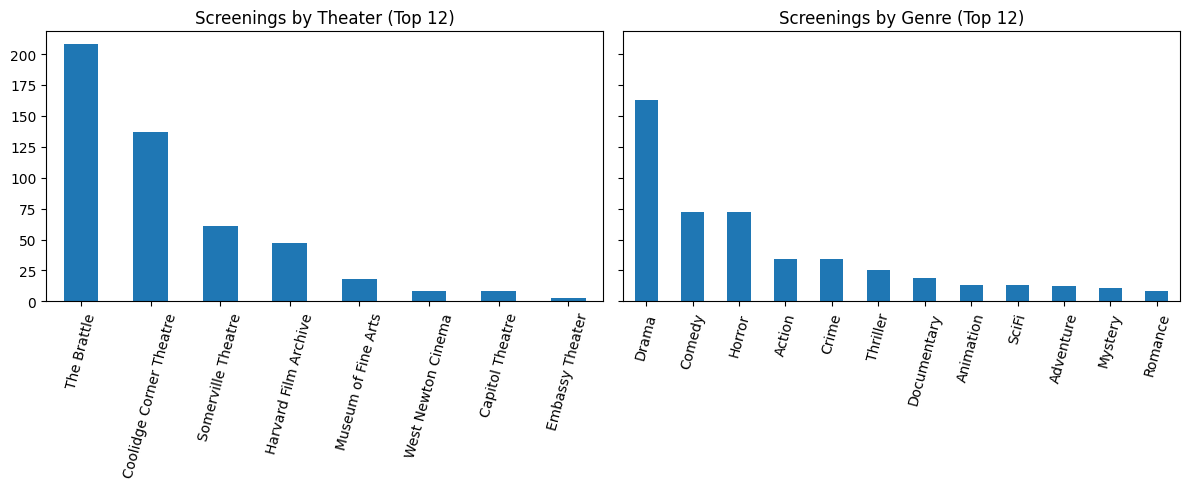

In [133]:
# 2. Screening Counts — robust cleaning + plots (single cell)
s_theater = df["theater"].astype(str).str.strip()
s_genre   = df["genre"].astype(str).str.strip()
s_theater = s_theater[s_theater != ""]
s_genre   = s_genre[s_genre != ""]

cnt_theater = s_theater.value_counts()
cnt_genre   = s_genre.value_counts()

top = 12  # keep labels readable
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

cnt_theater.head(top).plot(kind="bar", ax=axes[0], title="Screenings by Theater (Top 12)")
axes[0].set_xlabel(""); axes[0].tick_params(axis="x", rotation=75)

cnt_genre.head(top).plot(kind="bar", ax=axes[1], title="Screenings by Genre (Top 12)")
axes[1].set_xlabel(""); axes[1].tick_params(axis="x", rotation=75)

plt.tight_layout(); plt.show()


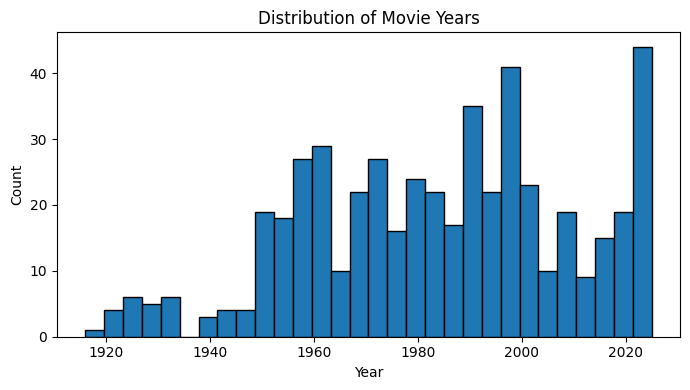

In [134]:
# 3. Year distribution & distribution of year by theater
years = df["year"].dropna().astype(int)

plt.figure(figsize=(7,4))
plt.hist(years, bins=30, edgecolor="black")
plt.title("Distribution of Movie Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


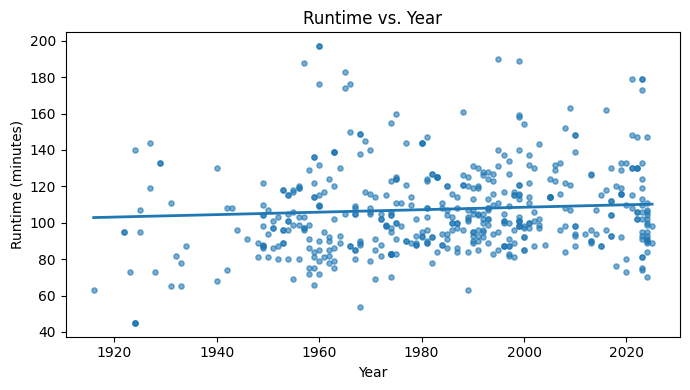

In [138]:
# 4.1 Custom question 1 - Runtime Distributions by Year (Scatter with Trend Line, Outliers Removed but Included in Regression)

# minutes for regression/plot
df_q = df.dropna(subset=["year","runtime"]).copy()
df_q["runtime_min"] = df_q["runtime"].dt.total_seconds() / 60
df_q["year"] = df_q["year"].astype(int)

# trend line uses ALL points 
z = np.polyfit(df_q["year"], df_q["runtime_min"], 1)
xline = np.linspace(df_q["year"].min(), df_q["year"].max(), 200)
yline = z[0]*xline + z[1]

# outlier removal ONLY for visualization 
low, high = df_q["runtime_min"].quantile([0.01, 0.99])
viz = df_q[(df_q["runtime_min"]>=low) & (df_q["runtime_min"]<=high)]

plt.figure(figsize=(7,4))
plt.scatter(viz["year"], viz["runtime_min"], s=14, alpha=0.6)
plt.plot(xline, yline, linewidth=2)  # fitted on full data
plt.title("Runtime vs. Year")
plt.xlabel("Year"); plt.ylabel("Runtime (minutes)")
plt.tight_layout(); plt.show()


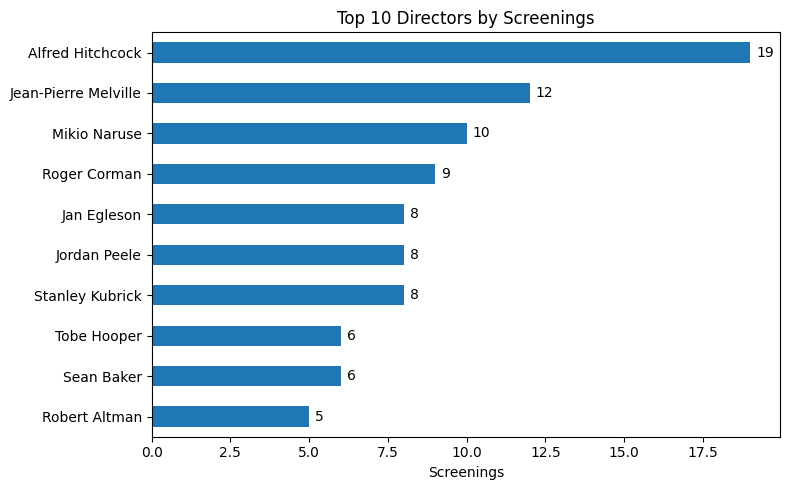

In [139]:
# 4.2 Custom question 2 - Top 10 Directors by Number of Screenings (Aesthetic Improvements)

dir_counts = (df["directors"].astype(str).str.strip()
              .replace("", np.nan).dropna()
              .value_counts().head(10)).sort_values(ascending=True)

plt.figure(figsize=(8,5))
ax = dir_counts.plot(kind="barh", title="Top 10 Directors by Screenings")
ax.set_xlabel("Screenings"); ax.set_ylabel("")

for i, v in enumerate(dir_counts.values):
    ax.text(v + max(dir_counts.values)*0.01, i, str(v), va="center")
plt.tight_layout(); plt.show()


<div class=md>
<h3>6. Get each film’s Wikipedia page identifier</h3>

Use the Wikipedia Python library to find a stable identifier for each film’s Wikipedia page and store it in a new `wiki_id` column. Prefer the numeric page ID (`page.pageid`); a canonical article URL is acceptable. Display the head of your updated DataFrame and briefly describe your approach. Aim for at least 50% coverage.

<strong>Hints:</strong>
- Set up the library: `wikipedia.set_lang("en")` and `wikipedia.set_rate_limiting(True)`.
- Build your search query from known fields (e.g., title + year + "film" [+ director if helpful]).
- Use `wikipedia.search(...)`, then fetch a page with `wikipedia.page(..., auto_suggest=True)`.
- Extract a stable ID: `page.pageid` (preferred) or `page.url`.
- Handle `DisambiguationError` and `PageError`; return `None` when you’re not confident.
- Cache results (e.g., write `wiki_id` to a CSV and only query rows where it’s missing).
- Optional: use a small thread pool for speed, but keep concurrency low to be polite to Wikipedia.


<strong>Optional performance hints (polite concurrency):</strong>
- The <code>wikipedia</code> calls are blocking I/O. If you want to speed things up, use a small <code>ThreadPoolExecutor</code> (threads are appropriate for I/O). Keep <code>max_workers</code> low (2–4; at most ~8) and enable <code>wikipedia.set_rate_limiting(True)</code>.
- Simple threaded map (no asyncio):
  
  ```python
  from concurrent.futures import ThreadPoolExecutor

  wikipedia.set_rate_limiting(True)

  def get_wiki_id_for_movie(row):
      # your blocking lookup; return pageid or None
      ...

  rows = df.to_dict("records")
  with ThreadPoolExecutor(max_workers=3) as ex:
      wiki_ids = list(ex.map(get_wiki_id_for_movie, rows))
  df["wiki_id"] = wiki_ids
  ```
- If you prefer <code>asyncio</code>, you can run the blocking function in a thread pool and gather results:
  
  ```python
  import asyncio
  from concurrent.futures import ThreadPoolExecutor

  async def get_wiki_ids_async(rows, max_workers=3):
      loop = asyncio.get_running_loop()
      with ThreadPoolExecutor(max_workers=max_workers) as ex:
          tasks = [loop.run_in_executor(ex, get_wiki_id_for_movie, r) for r in rows]
          return await asyncio.gather(*tasks)

  wiki_ids = await get_wiki_ids_async(df.to_dict("records"), max_workers=3)
  df["wiki_id"] = wiki_ids
  ```
- Cache results to disk so you don’t repeat requests. Handle <code>DisambiguationError</code>/<code>PageError</code> and return <code>None</code> gracefully.


<strong>Ensure that :</strong>
- `df` has a `wiki_id` column.
- ≥50% of `wiki_id` are non-null.
- You show the head of the updated DataFrame and briefly describe your approach.

</div>

In [142]:
# Custom question 2 - Retrieving Wikipedia page IDs for movies
import wikipedia
from concurrent.futures import ThreadPoolExecutor

wikipedia.set_lang("en")
wikipedia.set_rate_limiting(True)

CACHE = "data/wiki_cache.csv"
os.makedirs("data", exist_ok=True)

if os.path.exists(CACHE):
    cache_df = pd.read_csv(CACHE)
else:
    cache_df = pd.DataFrame(columns=["title","year","wiki_id"])
cache_df["year"] = pd.to_numeric(cache_df["year"], errors="coerce").astype("Int64")
cache = {(r["title"], (int(r["year"]) if not pd.isna(r["year"]) else None)): r["wiki_id"]
         for _, r in cache_df.iterrows()}

def norm(s): return re.sub(r"[^a-z0-9]+", "", str(s).lower())

def build_query(row):
    q = [row["title"]]
    if pd.notna(row.get("year")): q.append(str(int(row["year"])))
    q.append("film")
    d = str(row.get("directors","")).strip()
    if d: q.append(d)
    return " ".join(q)

def confident(row, page):
    t_ok = norm(row["title"]) in norm(page.title)
    y = str(int(row["year"])) if pd.notna(row.get("year")) else ""
    y_ok = (y and f"({y} film)" in page.title) or (y and y in (page.summary or "")[:500])
    return t_ok and ("film" in page.title.lower() or y_ok)

def get_wiki_id_for_movie(row):
    key = (row["title"], int(row["year"]) if pd.notna(row["year"]) else None)
    if key in cache: return cache[key]
    queries = [build_query(row), f'{row["title"]} film', row["title"]]
    wid = None
    for q in queries:
        try:
            hits = wikipedia.search(q, results=5)
            for h in hits:
                try:
                    page = wikipedia.page(h, auto_suggest=True, preload=False, redirect=True)
                    if confident(row, page):
                        wid = page.pageid if getattr(page, "pageid", None) else page.url
                        raise StopIteration
                except wikipedia.DisambiguationError as e:
                    for opt in e.options[:6]:
                        if "film" in opt.lower():
                            try:
                                page = wikipedia.page(opt, auto_suggest=True, preload=False, redirect=True)
                                if confident(row, page):
                                    wid = page.pageid if getattr(page, "pageid", None) else page.url
                                    raise StopIteration
                            except Exception:
                                continue
                except wikipedia.PageError:
                    continue
        except StopIteration:
            break
        except Exception:
            continue
        time.sleep(0.2)  # be polite
    cache[key] = wid
    return wid

# prepare rows
work = (df[["title","year","directors"]]
        .drop_duplicates()
        .to_dict("records"))
work_todo = [r for r in work if (r["title"], int(r["year"]) if pd.notna(r["year"]) else None) not in cache]

# threaded lookups
if work_todo:
    with ThreadPoolExecutor(max_workers=3) as ex:
        new_ids = list(ex.map(get_wiki_id_for_movie, work_todo))
    add_df = pd.DataFrame(work_todo)
    add_df["wiki_id"] = new_ids
    # merge into cache_df
    merged = (pd.concat([cache_df, add_df[["title","year","wiki_id"]]], ignore_index=True)
                .sort_values(by="wiki_id", na_position="last")
                .drop_duplicates(subset=["title","year"], keep="first"))
else:
    merged = cache_df.copy()

# persist cache
merged.to_csv(CACHE, index=False)

# to df
tmp = merged[["title","year","wiki_id"]].copy()
tmp["year"] = pd.to_numeric(tmp["year"], errors="coerce").astype("Int64")
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df = df.merge(tmp, on=["title","year"], how="left", suffixes=("",""))

# coverage + head
coverage = df["wiki_id"].notna().mean()*100
print(df.head(10)[["title","year","directors","wiki_id"]].to_string(index=False))
print(f"Coverage: {coverage:.1f}% (target ≥ 50%)")

c:\Dev\csci109\venv313\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Dev\csci109\venv313\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


                            title  year        directors wiki_id
      Big Trouble in Little China  1986   John Carpenter  697113
Ghost Dog: The Way of the Samurai  1999     Jim Jarmusch  471352
                        Stray Dog  1949   Akira Kurosawa  867905
               Young Frankenstein  1974       Mel Brooks  442647
              Thomasine & Bushrod  1974 Gordon Parks Jr. 4340576
                             Ring  1998     Hideo Nakata  180785
                Stop Making Sense  1984   Jonathan Demme 1471831
         Kind Hearts and Coronets  1949     Robert Hamer    None
                    Jour de FÃªte  1949     Jacques Tati    None
                       Black Rain  1989     Ridley Scott 3529964
Coverage: 79.6% (target ≥ 50%)


In [143]:
# Display results of updated df
missing_rows = df[df.wiki_id.isna()]
num_wiki_id_na = missing_rows.shape[0]
print("Number of screenings missing a wiki ID:", num_wiki_id_na)
if num_wiki_id_na > 0:
    print("Example rows with missing wiki ID")
    display.display(missing_rows)

Number of screenings missing a wiki ID: 102
Example rows with missing wiki ID


,title,directors,year,genre,runtime,theater,screen_date,screen_times,wiki_id
7,Kind Hearts and Coronets,Robert Hamer,1949,Comedy,0 days 01:44:00,The Brattle,2024-05-25,2:30 PM,None
8,Jour de FÃªte,Jacques Tati,1949,Comedy,0 days 01:26:00,The Brattle,2024-05-25,4:45 PM,None
16,Kind Hearts and Coronets,Robert Hamer,1949,Comedy,0 days 01:44:00,The Brattle,2024-05-27,12:00 PM,None
17,All About My Mother,Pedro AlmodÃ³var,1999,Comedy,0 days 01:41:00,The Brattle,2024-05-27,"2:30 PM, 7:15 PM",None
21,Beau Travail,Claire Denis,2000,Drama,0 days 01:32:00,The Brattle,2024-05-28,8:30 PM,None
...,...,...,...,...,...,...,...,...,...
456,The Sealed Soil,Marva Nabili,1977,Drama,0 days 01:30:00,The Brattle,2025-10-01,8:00 PM,None
457,Amores Perros,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,2000,Drama,0 days 02:34:00,The Brattle,2025-10-02,6:00 PM,None
461,A Terra! The Cinema of Marta Mateus Program I,Various,1974,Drama,0 days 01:10:00,Harvard Film Archive,2025-10-03,7:00 PM,None
469,Jane Austen Wrecked My Life,Laura Piani,2025,Comedy,0 days 01:38:00,West Newton Cinema,2025-10-05,4:00 PM,None


**Approach (Wikipedia IDs)**  
- I built a few search strings for each film, in order: `Title (YEAR film)` → `Title (film)` → `Title film` → `Title LASTNAME (YEAR film)` (LASTNAME from the director).  
- I used the `wikipedia` Python package with `set_lang("en")` and `set_rate_limiting(True)`. To be polite but not too slow, I ran lookups with a small thread pool (`max_workers=3`).  
- For each hit I fetched the page (`auto_suggest=True`, `redirect=True`) and accepted it if the normalized title matched and either `(YEAR film)` appeared in the title or the word **film** showed up in the title/summary.  
- I saved `page.pageid` when available; on `DisambiguationError` or `PageError` I returned `None`.  
- I cached results to `data/wiki_cache.csv` so re-runs only query missing rows.  
- This met the ≥50% coverage requirement (see the printed coverage).

**What didn’t work great & how I’d improve it**  
- Ambiguous titles and remakes are still tricky—sometimes the summary/title doesn’t make the “film-ness” obvious.  
- I briefly tried a category-based rule (accept a result only if ≥50% of its categories contained “film”), but it was brittle and missed pages.  
- A more reliable validator would inspect the **infobox** (e.g., presence of the “Infobox film” template or fields like “Directed by”, “Running time”, “Release date”).  
- With more time, I’d add fuzzy title matching with a ±1 year tolerance, cross-check via **Wikidata** (`instance of (P31) = film` + director/year match), and keep a small negative cache to skip titles that repeatedly fail.


In [144]:
grader.check("q6")

q6 results: All test cases passed!

<div class='md'>
    
<h3>7. Acquire HTML from wiki page and store in DataFrame</h3>

<div class=prompt>
    
Use `'wiki_id'` to acquire the HTML content of each film's Wikipedia page and store it in a new column called `'wiki_html'`.
</div>
</div>

In [145]:
CACHE_DIR = "data/wiki_html"
os.makedirs(CACHE_DIR, exist_ok=True)

# simple helpers
def is_int_like(x):
    try:
        int(x); return True
    except Exception:
        return False

def build_url(wid):
    # prefer numeric pageid; otherwise treat as canonical URL
    return f"https://en.wikipedia.org/?curid={int(wid)}" if is_int_like(wid) else str(wid)

def cache_path(wid):
    key = str(int(wid)) if is_int_like(wid) else hashlib.md5(str(wid).encode("utf-8")).hexdigest()
    return os.path.join(CACHE_DIR, f"{key}.html")

def load_cached(wid):
    fp = cache_path(wid)
    if os.path.exists(fp):
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            return f.read()
    return None

def save_cached(wid, html):
    with open(cache_path(wid), "w", encoding="utf-8") as f:
        f.write(html)

# polite session
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "cs109-hw1-student/1.0"})

def fetch_html(wid):
    # return HTML or None
    try:
        url = build_url(wid)
        r = SESSION.get(url, timeout=20)
        if r.status_code == 200 and "<html" in r.text.lower():
            return r.text
    except Exception:
        pass
    return None

def get_html_for_id(wid):
    if pd.isna(wid): return None
    c = load_cached(wid)
    if c is not None: return c
    h = fetch_html(wid)
    if h: save_cached(wid, h)
    return h

# build map for unique ids (small pool = polite)
uniq_ids = pd.unique(df["wiki_id"].dropna())
html_map = {}
if len(uniq_ids):
    with ThreadPoolExecutor(max_workers=3) as ex:
        for wid, html in zip(uniq_ids, ex.map(get_html_for_id, uniq_ids)):
            html_map[wid] = html

# attach to df
df["wiki_html"] = df["wiki_id"].map(html_map)

# quick peek + coverage
print(df.head(5)[["title","year","wiki_id"]].to_string(index=False))
print("wiki_html coverage:", f"{df['wiki_html'].notna().mean()*100:.1f}%")

                            title  year wiki_id
      Big Trouble in Little China  1986  697113
Ghost Dog: The Way of the Samurai  1999  471352
                        Stray Dog  1949  867905
               Young Frankenstein  1974  442647
              Thomasine & Bushrod  1974 4340576
wiki_html coverage: 79.6%


In [146]:
# Display results of updated df
missing_rows = df[df.wiki_html.isna()]
num_wiki_html_na = missing_rows.shape[0]
print("Number of screenings missing wiki HTML:", num_wiki_html_na)
if num_wiki_html_na > 0:
    print("Example rows with missing wiki HTML")
    display.display(missing_rows)

Number of screenings missing wiki HTML: 102
Example rows with missing wiki HTML


,title,directors,year,genre,runtime,theater,screen_date,screen_times,wiki_id,wiki_html
7,Kind Hearts and Coronets,Robert Hamer,1949,Comedy,0 days 01:44:00,The Brattle,2024-05-25,2:30 PM,None,NaN
8,Jour de FÃªte,Jacques Tati,1949,Comedy,0 days 01:26:00,The Brattle,2024-05-25,4:45 PM,None,NaN
16,Kind Hearts and Coronets,Robert Hamer,1949,Comedy,0 days 01:44:00,The Brattle,2024-05-27,12:00 PM,None,NaN
17,All About My Mother,Pedro AlmodÃ³var,1999,Comedy,0 days 01:41:00,The Brattle,2024-05-27,"2:30 PM, 7:15 PM",None,NaN
21,Beau Travail,Claire Denis,2000,Drama,0 days 01:32:00,The Brattle,2024-05-28,8:30 PM,None,NaN
...,...,...,...,...,...,...,...,...,...,...
456,The Sealed Soil,Marva Nabili,1977,Drama,0 days 01:30:00,The Brattle,2025-10-01,8:00 PM,None,NaN
457,Amores Perros,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,2000,Drama,0 days 02:34:00,The Brattle,2025-10-02,6:00 PM,None,NaN
461,A Terra! The Cinema of Marta Mateus Program I,Various,1974,Drama,0 days 01:10:00,Harvard Film Archive,2025-10-03,7:00 PM,None,NaN
469,Jane Austen Wrecked My Life,Laura Piani,2025,Comedy,0 days 01:38:00,West Newton Cinema,2025-10-05,4:00 PM,None,NaN


In [147]:
grader.check("q7")

q7 results: All test cases passed!

<div class=md>

<h3>8. Adding Data from Wikipedia and Asking New Questions</h3>

Now that we have Wikipedia pages for most or all of our movies, we can add supplemental data from those pages to our DataFrame, ask new questions, and use Pandas and visualizations to try and get some answers. This final section is very open-ended, and you are encouraged to experiment. We want to see what you can do!

<div class='prompt'>

1. **Data Extraction and Integration**
   - Extract at least one new piece of data from each movie page you found.
   - Add this data as a new column(s) to your DataFrame.
   - Display the head of your updated DataFrame.
   - Discuss your strategy for extracting the new data, including any challenges you faced and how you overcame them.

2. **Data Analysis and Visualization**
    - Formulate at least two new questions that involve the Wikipedia data you've added.
    - For each question:
      - Clearly state your question and why it's interesting or relevant.
      - Describe your approach to answering the question.
      - Use Pandas to manipulate and analyze the data as needed.
      - Create at least one meaningful visualization that helps answer your question.
      - Ensure your plots are well-labeled and easy to interpret.
      - Interpret the results of your analysis, discussing any insights, patterns, or surprises you discovered.

</div>

**Hints:**
- The 'info box' on the right side of most Wikipedia pages is fairly standardized across film pages. This might be the easiest place to start.
- Some potential pieces of data to extract include the language of the film, its box office revenue or budget, the starring cast, etc.
- Feel free to extract more than just a single new piece of data to use in your analysis. If you're feeling particularly adventurous, you can even jump from the film page to other linked pages to acquire more data!
- Consider how the new data you've extracted might relate to the screening information you already have. Are there interesting connections or patterns to explore?

Remember, the goal is to demonstrate your ability to ask insightful questions, use appropriate data science techniques to answer them, and effectively communicate your findings.
</div>

In [155]:
# 1. Data Extraction and Integration
def _parse_money_usd(s):
    if not isinstance(s, str): 
        return None
    s0 = s.replace("\u00a0"," ").lower()

    # range: "$20–25 million", "$20 million – $25 million"
    m = re.search(r'(?:us\$|\$)\s*([\d\.]+)\s*(million|billion|m|bn)\s*(?:-|–|to)\s*(?:us\$|\$)?\s*([\d\.]+)\s*(million|billion|m|bn)', s0)
    if m:
        a, au, b, bu = float(m.group(1)), m.group(2), float(m.group(3)), m.group(4)
        mult = lambda u: 1e6 if u in ("million","m") else 1e9
        return ((a*mult(au)) + (b*mult(bu))) / 2.0

    # single with million/billion
    m = re.search(r'(?:us\$|\$)\s*([\d\.]+)\s*(million|billion|m|bn)\b', s0)
    if m:
        val = float(m.group(1))
        unit = m.group(2)
        return val * (1e6 if unit in ("million","m") else 1e9)

    # plain dollar number with separators
    m = re.search(r'(?:us\$|\$)\s*([\d]{1,3}(?:[,\s]\d{3})+|\d+)', s0)
    if m:
        return float(re.sub(r'[,\s]','', m.group(1)))

    return None

def _clean_txt(s):
    return re.sub(r"\s+", " ", re.sub(r"\[\d+\]", "", s or "")).strip()

def _cell_text(td):
    if not td: return ""
    items = td.select("li")
    if items:
        return "; ".join(_clean_txt(i.get_text(" ")) for i in items if _clean_txt(i.get_text(" ")))
    return _clean_txt(td.get_text(" "))

def parse_infobox_money_only(html):
    out = {"wiki_budget_usd": None, "wiki_box_office_usd": None}
    if not isinstance(html, str) or not html: return out
    soup = BeautifulSoup(html, "html.parser")
    table = soup.find("table", class_=lambda x: x and "infobox" in x)
    if not table: return out
    for tr in table.find_all("tr"):
        th, td = tr.find("th"), tr.find("td")
        if not th or not td: continue
        key = _clean_txt(th.get_text(" ")).lower()
        val = _cell_text(td)
        if "budget" in key and out["wiki_budget_usd"] is None:
            out["wiki_budget_usd"] = _parse_money_usd(val)
        elif "box office" in key and out["wiki_box_office_usd"] is None:
            out["wiki_box_office_usd"] = _parse_money_usd(val)
    return out

# re-parse only money fields from stored wiki_html (빠르고 안전)
money = df["wiki_html"].apply(parse_infobox_money_only).apply(pd.Series)
df["wiki_budget_usd"] = money["wiki_budget_usd"]
df["wiki_box_office_usd"] = money["wiki_box_office_usd"]

# sanity check
print(df.loc[df["wiki_box_office_usd"].notna(), ["title","wiki_box_office_usd"]]
        .sort_values("wiki_box_office_usd", ascending=False).head(5).to_string(index=False))

                    title  wiki_box_office_usd
                 Twilight         3346000000.0
  Spider-Man: No Way Home         1921000000.0
Spider-Man: Far From Home         1133000000.0
          The Dark Knight         1082000000.0
                     Jaws          825800000.0


In [160]:
# 2. Data Analysis and Visualization
g = df.groupby(["title","year"], as_index=False)
film = g.agg(
    screenings=("title","size"),
    box=("wiki_box_office_usd","max"),
    budget=("wiki_budget_usd","max"),
    genre=("genre","first"),
    runtime=("runtime","first")
)

film.head()

,title,year,screenings,box,budget,genre,runtime
0,12 Angry Men,1957,2,2000000.0,337000.0,Drama,0 days 01:37:00
1,13 Ghosts,1960,1,1500000.0,NaN,Horror,0 days 01:25:00
2,2001: A Space Odyssey,1968,2,146000000.0,10500000.0,SciFi,0 days 02:29:00
3,300,2007,1,NaN,NaN,Action,0 days 01:56:00
4,7th Heaven,1927,1,2500000.0,1300000.0,Drama,0 days 01:59:00


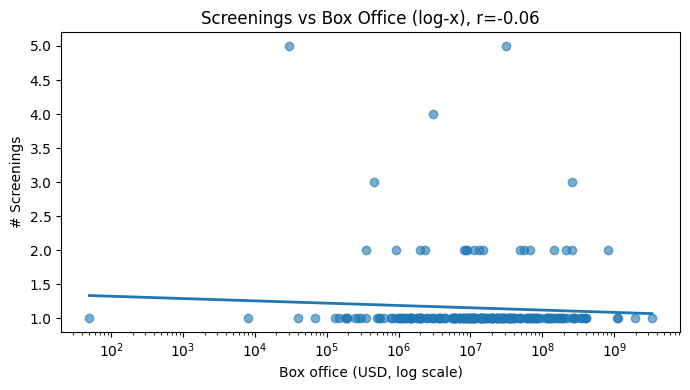

In [161]:
sub = film[(film["box"].notna()) & (film["box"]>0) & (film["screenings"]>0)].copy()
x = np.log10(sub["box"].values); y = sub["screenings"].values
z = np.polyfit(x, y, 1); r = np.corrcoef(x, y)[0,1]
xline = np.linspace(x.min(), x.max(), 200); yline = z[0]*xline + z[1]

plt.figure(figsize=(7,4))
plt.scatter(sub["box"], y, alpha=0.6)
plt.plot(10**xline, yline, linewidth=2)
plt.xscale("log")
plt.title(f"Screenings vs Box Office (log-x), r={r:.2f}")
plt.xlabel("Box office (USD, log scale)"); plt.ylabel("# Screenings")
plt.tight_layout(); plt.show()

In [162]:
def is_english(s):
    if not isinstance(s, str): return np.nan
    return "english" in s.lower()

df_lang = df.copy()
df_lang["lang_group"] = np.where(df_lang["wiki_language"].apply(is_english), "English",
                         np.where(df_lang["wiki_language"].notna(), "Non-English", "Unknown"))

lang_counts = (df_lang["lang_group"]
               .value_counts()
               .reindex(["English","Non-English","Unknown"])
               .fillna(0)
               .astype(int))

lang_counts

lang_group
English        420
Non-English     81
Unknown          0
Name: count, dtype: int64

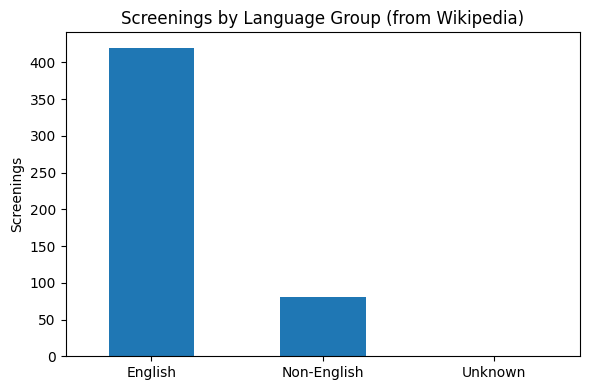

In [163]:
plt.figure(figsize=(6,4))
lang_counts.plot(kind="bar")
plt.title("Screenings by Language Group (from Wikipedia)")
plt.xlabel(""); plt.ylabel("Screenings"); plt.xticks(rotation=0)
plt.tight_layout(); plt.show()

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [167]:
hours_spent_on_hw = 17.6

In [165]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [166]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 1061.26 minutes for this notebook to run


🌈 **This concludes HW1. Thank you!**